In [1]:
# Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
# SPDX-License-Identifier: Apache-2.0

import numpy as np
import pandas as pd
import sys
import pickle as pkl
import matplotlib.pyplot as plt
import os 
from itertools import combinations

sys.path.append('/zfsauton2/home/mgoswami/PyMAD/') # TODO: Make this relative path maybe
sys.path.append('/zfsauton2/home/mgoswami/VUS/')
sys.path.append('/zfsauton2/home/mgoswami/tsad-model-selection/src/')

from model_selection.model_selection import RankModels
from model_trainer.entities import ANOMALY_ARCHIVE_ENTITIES, ANOMALY_ARCHIVE_10_ENTITIES, MACHINES
from model_selection.utils import visualize_predictions, visualize_data
from model_selection.rank_aggregation import trimmed_borda, trimmed_kemeny, trimmed_partial_borda, borda, kemeny, partial_borda, influence, averagedistance
from metrics.metrics import evaluate_model_selection
from metrics.ranking_metrics import rank_by_centrality, rank_by_synthetic_anomlies, rank_by_forecasting_metrics, rank_by_metrics
from model_selection.model_selection_utils import rank_models

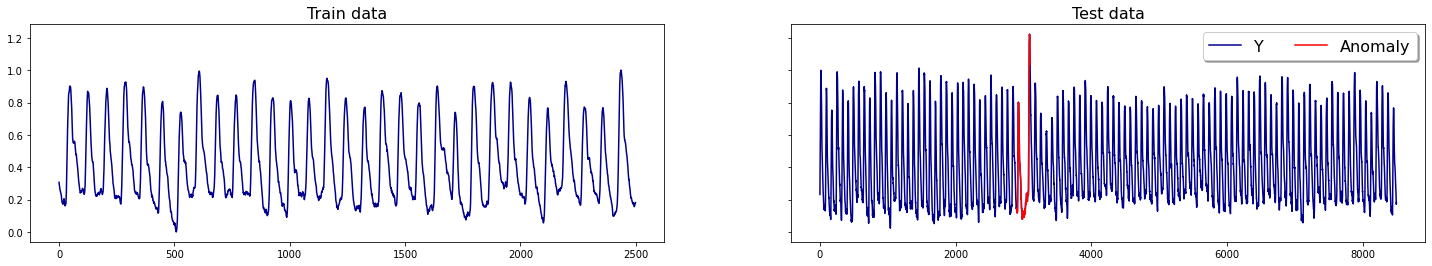

In [19]:
### Load the ranking object

DATASET = 'anomaly_archive' # 'smd' # 'anomaly_archive'
ENTITY = '004_UCR_Anomaly_DISTORTEDBIDMC1' # 'machine-1-1' # '028_UCR_Anomaly_DISTORTEDInternalBleeding17'
EXPERIMENT_DATE = 'Oct29'
SAVE_DIR = f'/home/scratch/mgoswami/Experiments_{EXPERIMENT_DATE}/results'
ranking_obj_file = f'ranking_obj_{ENTITY}.data'

with open(os.path.join(SAVE_DIR, DATASET, ranking_obj_file), 'rb') as f: 
    rankingObj = pkl.load(f)

visualize_data(train_data=rankingObj.train_data, test_data=rankingObj.test_data)

In [15]:
ranks_by_metrics, *_ = rank_models(rankingObj.models_performance_matrix)
ranks = np.concatenate([ranks_by_metrics[:8, :], ranks_by_metrics[8::2, :]], axis=0).astype(int) # Pick rank by F1
performance_values = rankingObj.models_performance_matrix.loc[:, 'Best F-1'].to_numpy().squeeze()

In [22]:
rank_quality = []
for r in range(ranks.shape[0]):
    # rank_quality.append(performance_values[ranks[r, :5]].mean())
    rank_quality.append(performance_values[ranks[r, :5]].mean())

rank_quality = np.array(rank_quality)
ranked_rank_quality = np.argsort(-1*rank_quality)
ranked_ranks = ranks[ranked_rank_quality, :]

print(rank_quality)
print(ranked_rank_quality)
print(rank_quality[ranked_rank_quality])

[0.88387599 0.49054067 0.72036497 0.64030076 0.85424807 0.85993113
 0.86422925 0.85424807 0.85424807 0.87012506 0.85916837 0.86869783
 0.86557445 0.86527658 0.85974809 0.87331237 0.86097847]
[ 0 15  9 11 12 13  6 16  5 14 10  4  7  8  2  3  1]
[0.88387599 0.87331237 0.87012506 0.86869783 0.86557445 0.86527658
 0.86422925 0.86097847 0.85993113 0.85974809 0.85916837 0.85424807
 0.85424807 0.85424807 0.72036497 0.64030076 0.49054067]


In [23]:
n_metrics = 10
print(f'Average performance of top-{n_metrics}: {rank_quality[ranked_rank_quality][:n_metrics].mean()}')

pairs = np.arange(2, n_metrics+1)[::2]
print(f'Evaluation for {pairs} pairs...')
ranked_ranks = ranked_ranks[:n_metrics, :]

for pair in pairs: # Number of metrics to consider
    average_performance = []
    for rs in combinations(np.arange(n_metrics), pair):
        _, borda_rank = borda(ranked_ranks[rs, :])
        borda_rank = borda_rank.astype(int)
        average_performance.append(performance_values[borda_rank][:5].mean())
    print(f'For {pair} pairs: {np.mean(average_performance)}')

n_metrics = 10
print(f'Average performance of top-{n_metrics}: {rank_quality[ranked_rank_quality][:n_metrics].mean()}')

Average performance of top-10: 0.8671749218108262
Evaluation for [ 2  4  6  8 10] pairs...
For 2 pairs: 0.7771173892302292
For 4 pairs: 0.793431487739276
For 6 pairs: 0.7995285221068313
For 8 pairs: 0.7946037950834082
For 10 pairs: 0.8515611117797872
Average performance of top-10: 0.8671749218108262


In [ ]:
### Load the ranking object

DATASET = 'anomaly_archive' # 'smd' # 'anomaly_archive'
EXPERIMENT_DATE = 'Oct29'
SAVE_DIR = f'/home/scratch/mgoswami/Experiments_{EXPERIMENT_DATE}/results'
top_k_models = 5

for ENTITY in ANOMALY_ARCHIVE_10_ENTITIES:    
    entity_performance_dict = {}
    ranking_obj_file = f'ranking_obj_{ENTITY}.data'

    try:
        with open(os.path.join(SAVE_DIR, DATASET, ranking_obj_file), 'rb') as f: 
            rankingObj = pkl.load(f)    
    except:
        continue
    
    print(f'Entity: {ENTITY}')
        
    ranks_by_metrics, *_ = rank_models(rankingObj.models_performance_matrix)
    ranks = np.concatenate([ranks_by_metrics[:8, :], ranks_by_metrics[8::2, :]], axis=0).astype(int) # Pick rank by F1
    performance_values = rankingObj.models_performance_matrix.loc[:, 'Best F-1'].to_numpy().squeeze()

    rank_quality = []
    for r in range(ranks.shape[0]):
        rank_quality.append(performance_values[ranks[r, :top_k_models]].mean())

    rank_quality = np.array(rank_quality)
    ranked_rank_quality = np.argsort(-1*rank_quality)
    ranked_ranks = ranks[ranked_rank_quality, :]
    print(rank_quality[ranked_rank_quality])

    n_metrics = 10
    print(f'Average performance of top-{n_metrics}: {rank_quality[ranked_rank_quality][:n_metrics].mean()}')

    pairs = np.arange(2, n_metrics+1)[::2]
    # print(f'Evaluation for {pairs} pairs...')
    ranked_ranks = ranked_ranks[:n_metrics, :]

    for pair in pairs: # Number of metrics to consider
        average_performance = []
        for rs in combinations(np.arange(n_metrics), pair):
            _, borda_rank = borda(ranked_ranks[rs, :])
            borda_rank = borda_rank.astype(int)
            average_performance.append(performance_values[borda_rank][:top_k_models].mean())
        print(f'For {pair} pairs: {np.mean(average_performance)}')

### Consider two models only

In [20]:
mpm = rankingObj.models_performance_matrix.sort_values(by='Best F-1')
mpm = mpm.iloc[[0, -1], :]

ranks_by_metrics, *_ = rank_models(mpm)
ranks = np.concatenate([ranks_by_metrics[:8, :], ranks_by_metrics[8::2, :]], axis=0).astype(int) # Pick rank by F1
performance_values = mpm.loc[:, 'Best F-1'].to_numpy().squeeze()
performance_values[0] = 0
performance_values[1] = 1

In [21]:
n_metrics = 17
pairs = np.arange(3, n_metrics+1)[::2]

for pair in pairs: # Number of metrics to consider
    average_performance = []
    for rs in combinations(np.arange(n_metrics), pair):
        _, borda_rank = borda(ranks[rs, :])
        borda_rank = borda_rank.astype(int)
        average_performance.append(performance_values[borda_rank][0])
    print(f'For {pair} pairs: {np.mean(average_performance)}')

For 3 pairs: 0.27205882352941174
For 5 pairs: 0.20539754363283774
For 7 pairs: 0.14479638009049775
For 9 pairs: 0.08823529411764706
For 11 pairs: 0.03733031674208145
For 13 pairs: 0.0
For 15 pairs: 0.0
For 17 pairs: 0.0


In [25]:
rankingObj.models_performance_matrix.loc[:, 'Best F-1']

DGHL_1       0.999995
DGHL_2       0.977990
DGHL_3       0.999995
DGHL_4       0.950114
RNN_1        0.999995
RNN_2        0.975605
RNN_3        0.999995
RNN_4        0.985217
LSTMVAE_1    0.999995
LSTMVAE_2    0.999995
LSTMVAE_3    0.999995
LSTMVAE_4    0.999995
NN_1         0.917426
NN_2         0.917426
NN_3         0.917426
MD_1         0.999995
RM_1         0.995020
RM_2         0.999995
RM_3         0.999995
Name: Best F-1, dtype: float64

In [3]:
### Load the ranking object

DATASET = 'smd' # 'smd' # 'anomaly_archive'
EXPERIMENT_DATE = 'Oct29'
SAVE_DIR = f'/home/scratch/mgoswami/Experiments_{EXPERIMENT_DATE}/results'
n_metrics = 17
pairs = np.arange(3, n_metrics+1)[::2]
entity_performance_dict = {}

dataset_entity = {
    'smd': MACHINES, 
    'anomaly_archive': ANOMALY_ARCHIVE_ENTITIES, 
}

for DATASET in ['anomaly_archive', 'smd']:
    print('Dataset:', DATASET)
    for ENTITY in dataset_entity[DATASET]:        
        ranking_obj_file = f'ranking_obj_{ENTITY}.data'

        try:
            with open(os.path.join(SAVE_DIR, DATASET, ranking_obj_file), 'rb') as f: 
                rankingObj = pkl.load(f)    
        except:
            continue
        
        print(f'Entity: {ENTITY}')
            
        mpm = rankingObj.models_performance_matrix.sort_values(by='Best F-1')
        mpm = mpm.iloc[[0, -1], :]

        ranks_by_metrics, *_ = rank_models(mpm)
        ranks = np.concatenate([ranks_by_metrics[:8, :], ranks_by_metrics[8::2, :]], axis=0).astype(int) # Pick rank by F1
        performance_values = mpm.loc[:, 'Best F-1'].to_numpy().squeeze()
        performance_values[0] = 0
        performance_values[1] = 1

        entity_performance_dict[ENTITY] = []
        for pair in pairs: # Number of metrics to consider
            average_performance = []
            for rs in combinations(np.arange(n_metrics), pair):
                _, borda_rank = borda(ranks[rs, :])
                borda_rank = borda_rank.astype(int)
                average_performance.append(performance_values[borda_rank][0])
            print(f'Avg. perf. of all pairs of {pair} metrics: {np.mean(average_performance)}')
            entity_performance_dict[ENTITY].append(np.mean(average_performance))

Dataset: anomaly_archive
Entity: 125_UCR_Anomaly_ECG4
Avg. perf. of all pairs of 3 metrics: 0.9779411764705882
Avg. perf. of all pairs of 5 metrics: 1.0
Avg. perf. of all pairs of 7 metrics: 1.0
Avg. perf. of all pairs of 9 metrics: 1.0
Avg. perf. of all pairs of 11 metrics: 1.0
Avg. perf. of all pairs of 13 metrics: 1.0
Avg. perf. of all pairs of 15 metrics: 1.0
Avg. perf. of all pairs of 17 metrics: 1.0
Entity: 108_UCR_Anomaly_NOISEresperation2
Avg. perf. of all pairs of 3 metrics: 0.06323529411764706
Avg. perf. of all pairs of 5 metrics: 0.014705882352941176
Avg. perf. of all pairs of 7 metrics: 0.0
Avg. perf. of all pairs of 9 metrics: 0.0
Avg. perf. of all pairs of 11 metrics: 0.0
Avg. perf. of all pairs of 13 metrics: 0.0
Avg. perf. of all pairs of 15 metrics: 0.0
Avg. perf. of all pairs of 17 metrics: 0.0
Entity: 104_UCR_Anomaly_NOISEapneaecg4
Avg. perf. of all pairs of 3 metrics: 0.6397058823529411
Avg. perf. of all pairs of 5 metrics: 0.6855203619909502
Avg. perf. of all pairs

In [4]:
performance = []
for ent in entity_performance_dict.keys():
    if entity_performance_dict[ent][0] > 0.2:
        performance.append(entity_performance_dict[ent])

In [5]:
performance = np.array(performance)

In [6]:
performance.mean(axis=0)

array([0.81362824, 0.84965743, 0.87007438, 0.88163016, 0.88831132,
       0.89254584, 0.89497499, 0.89068826])

In [11]:
np.where(performance[:, -1] - performance[:, 0] < 0)

27

181

In [13]:
# # Now use to predictions to rank the model
# predictions = rankingObj.predictions
# synthetic_predictions = rankingObj.synthetic_predictions
# n_neighbors = [2, 4, 6]
# n_splits = 100

# models_metrics = rank_by_metrics(predictions, n_splits=100, sliding_window=None)
# models_forecasting_metrics = rank_by_forecasting_metrics(predictions)
# models_centrality = rank_by_centrality(predictions,
#                                         n_neighbors=n_neighbors)
# models_synthetic_anomlies = rank_by_synthetic_anomlies(
#     synthetic_predictions,
#     n_splits=n_splits)

# models_performance_matrix = pd.concat([
#     models_metrics, 
#     models_forecasting_metrics, 
#     models_centrality, 
#     models_synthetic_anomlies], axis=1)